<a href="https://colab.research.google.com/github/ancientpi3/GeoInferenceMachine/blob/main/Geotiff_Inference_Machine.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
from IPython.display import clear_output
!pip install rasterio
clear_output()

In [4]:
from google.colab import drive
from IPython.display import clear_output
import rasterio
import matplotlib.pyplot as plt
import numpy as np
import os
from PIL import Image
from tqdm import tqdm
from fastai.vision.all import *
from fastai.metrics import DiceMulti, foreground_acc
from fastai.losses import CrossEntropyLossFlat

In [5]:

# prompt: give me the imports I need to load in geotiff imagery

import rasterio
import matplotlib.pyplot as plt
import numpy as np
from rasterio.merge import merge

In [6]:
class GeoInferenceMachine:
    def __init__(self, geotiff_path,
                 tile_dimensions,
                 tiles_folder_path,
                 preds_folder_path,
                 model_path=None,
                 ):
        self.geotiff_path = geotiff_path
        self.tile_dimensions = tile_dimensions
        self.tiles_folder_path = tiles_folder_path
        self.tile_input_data_geo = {} # New dictionary to store geo-coordinates
        self.preds_folder_path = preds_folder_path
        self.model_path = model_path
        self.model = None
        if not os.path.exists(self.tiles_folder_path):
            os.makedirs(self.tiles_folder_path)
        if not os.path.exists(self.preds_folder_path):
            os.makedirs(self.preds_folder_path)
        # Add other instance variables as needed

    def multiband_to_png(self, tile):
        """
        Converts a multi-band image to a PNG image.
        Override this function to implement your custom conversion logic.
        """
        # Assuming the tile is a numpy array with shape (bands, height, width)
        # Convert each band to an 8-bit grayscale image
        images = []
        for band in range(tile.shape[0]):
            band_data = tile[band,:, :]

            # Normalize to 0-255 range
            min_val = np.min(band_data)
            max_val = np.max(band_data)
            normalized_band = ((band_data - min_val) / (max_val - min_val)) * 255

            # Convert to 8-bit unsigned integer
            normalized_band = normalized_band.astype(np.uint8)
            images.append(Image.fromarray(normalized_band))

    def tile_input_data(self):
        with rasterio.open(self.geotiff_path) as src:
            width = src.width
            height = src.height
            tile_width, tile_height = self.tile_dimensions
            tiles = []
            total_tiles = (height // tile_height) * (width // tile_width)
            with tqdm(total=total_tiles, desc="Tiling Progress") as pbar:
              for i in range(0, height, tile_height):
                  for j in range(0, width, tile_width):
                      window = rasterio.windows.Window(j, i, tile_width, tile_height)
                      tile = src.read(window=window)
                      if tile.shape[1] != tile_height or tile.shape[2] != tile_width:
                          tile = src.read(window=window,
                                          boundless=True,
                                          # fill_value=0,  # Value for out-of-bounds areas
                                          # out_shape=(height, width)
                                          )


                      png_image = self.multiband_to_png(tile)
                      tile_filename = os.path.join(self.tiles_folder_path, f"tile_{i}_{j}.png")
                      png_image.save(tile_filename)

                      # Store geo-coordinates
                      transform = src.window_transform(window)
                      self.tile_input_data_geo[tile_filename] = {
                          'transform': transform.to_gdal(),
                          'crs': src.crs.to_string()
                      }

                      pbar.update(1)

    def png_pred_to_geotiff(self, png_path, geo_info_path=None, pred=None):
            if geo_info_path is None:
                geo_info_path = self.tile_input_data_geo
            geo_info = geo_info_path[png_path]
            transform_tuple = geo_info['transform']
            transform = rasterio.Affine.from_gdal(*transform_tuple)
            crs = geo_info['crs']
            img_array = np.array(pred)
            # img_array = (img_array - img_array.min()) / (img_array.max() - img_array.min())
            # Construct the output path within self.preds_folder_path
            output_path = os.path.join(self.preds_folder_path, os.path.basename(png_path).replace('.png', '_pred.tif'))
            with rasterio.open(output_path, 'w', driver='GTiff',
                                height=img_array.shape[0], width=img_array.shape[1],
                                count=img_array.shape[2] if len(img_array.shape) > 2 else 1,
                                dtype=rasterio.float32,
                                crs=crs,
                                transform=transform) as dst:
                if len(img_array.shape) > 2:
                    dst.write(img_array)
                else:
                    dst.write(img_array, 1)


    def initialize_model(self):
        """
        Initializes the machine learning model.
        Override this function to implement your custom model initialization logic.
        """
        raise NotImplementedError("Subclasses must implement this method")


    def generate_inferences(self):
        """
        Runs ML inference on a tile.
        Override this function to implement your custom inference logic.
        """
        raise NotImplementedError("Subclasses must implement this method")

    def run(self):
        """
        Orchestrates the tiling, preprocessing, and inference process.
        """
        self.tile_input_data()
        # ... (rest of your run method)


In [7]:
# prompt: write me a subclass NDVIgbInferenceMachine that inherits from GeoInferenceMachine. Overwrite tile_input_data to tile up a geotiff (located at self.geotiff_path) according a an instance variable self.tile_dimensions (i.e [256,256] or [512,512]). For each tile, run a function called self.multiband_to_png(tile) to save the tile as png in a folder location self.tiles_folder_path

import os
from PIL import Image

class NDVIgbInferenceMachine(GeoInferenceMachine):
    def __init__(self, geotiff_path,
                 tile_dimensions,
                 tiles_folder_path,
                 preds_folder_path,
                 model_path=None):
        super().__init__(geotiff_path, tile_dimensions, tiles_folder_path, preds_folder_path, model_path)

    def create_NDVIgb_tile(self,x):

      urb = x[4].copy()
      perm = x[5].copy()
      perm[perm==-9999] = 0
      mask = (urb)*(perm==0) == 0

      NDVIgb = np.array([x[3]*mask, x[1]*mask, x[2]*mask]).transpose(1,2,0)

      NDVIgb = np.flipud(NDVIgb)

      # Rotate -90 degrees (clockwise)
      NDVIgb = np.rot90(NDVIgb, k=3)  # Rotate by 270 degrees counter-clockwise

      return NDVIgb

    def multiband_to_png(self, tile):
      NDVIgb = self.create_NDVIgb_tile(tile)
      image = Image.fromarray((255*NDVIgb).astype(np.uint8))
      #merged_image = Image.merge('RGB', images[:3]) # Merge first three bands as RGB
      return image

    def initialize_model(self):
        # Implement your model initialization logic here
        self.device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
        loss_func = CrossEntropyLossFlat(axis=1)
        empty_dls = DataLoaders(DataLoader([], bs=1), DataLoader([], bs=1))
        body = create_body(convnext_small(), n_in=3, pretrained=True)
        model = DynamicUnet(body[0], n_out=2, img_size=(244, 244))
        learn = Learner(empty_dls, model, loss_func=loss_func, cbs=[], lr=1e-3, wd=1e-3, metrics=[DiceMulti(), foreground_acc])
        learn.load(self.model_path)
        self.model = learn.model
        self.model.to(self.device)

    def combine_geotiffs(self, save_location):
      """
      Combines all GeoTIFFs in self.preds_folder_path into a single GeoTIFF.

      Args:
          save_location (str): The path to save the combined GeoTIFF.
      """

      search_criteria = os.path.join(self.preds_folder_path, '*.tif')
      geotiff_files = glob.glob(search_criteria)

      if not geotiff_files:
          print(f"No GeoTIFF files found in {self.preds_folder_path}")
          return

      src_files_to_mosaic = []
      for fp in geotiff_files:
          src = rasterio.open(fp)
          src_files_to_mosaic.append(src)

      mosaic, out_trans = merge(src_files_to_mosaic)

      # Copy the metadata
      out_meta = src.meta.copy()

      # Update the metadata
      out_meta.update({"driver": "GTiff",
                      "height": mosaic.shape[1],
                      "width": mosaic.shape[2],
                      "transform": out_trans,
                      "crs": src.crs})

      # Write the mosaic raster to disk
      with rasterio.open(save_location, "w", **out_meta) as dest:
          dest.write(mosaic)

      # Close the datasets
      for src in src_files_to_mosaic:
          src.close()

    def generate_inferences(self, batch_size=10):
        """
        Runs ML inference on tiles in batches.
        """
        self.initialize_model()
        tile_paths = [os.path.join(self.tiles_folder_path, tile_path) for tile_path in os.listdir(self.tiles_folder_path) if tile_path.endswith(".png")]

        for i in tqdm(range(0, len(tile_paths), batch_size), desc="Inference Progress"):
            batch_paths = tile_paths[i:i + batch_size]
            batch_images = []
            for tile_full_path in batch_paths:
                img = PILImage.create(tile_full_path)
                img_tensor = TensorImage(image2tensor(img)).type(torch.FloatTensor)/255.0
                batch_images.append(img_tensor)

            # Convert list of tensors to a single tensor
            batch_tensor = torch.stack(batch_images)
            batch_tensor = batch_tensor.to(self.device)

            # Perform inference on the batch
            with torch.no_grad(): # Use no_grad for inference
              # preds = self.model.eval()(batch_tensor).argmax(dim=1).cpu().numpy()
              preds = self.model.eval()(batch_tensor).cpu()  # Get raw predictions as numpy array
              preds = torch.softmax(preds, dim=1).numpy()
              preds = preds[:,1]
              # preds = preds[0, :, :, :]
            # Save predictions individually
            for j, pred in enumerate(preds):
                self.png_pred_to_geotiff(batch_paths[j], pred=pred)

In [8]:

# prompt: "/content/drive/MyDrive/GEE_exports/study_area/study_area_with_permit-0000000000-0000011776.tif" load this and run tiling with the above class

# Example usage
geotiff_file_path = "/content/drive/MyDrive/GEE_exports/study_area/study_area_with_permit-0000000000-0000011776.tif"
tile_size = (256, 256)  # Example tile dimensions
output_folder = "/content/tiles"
preds_folder = "/content/preds"
model_path = '/content/drive/MyDrive/MTM/MTM Fastai/mtm_convnext_10_1_24'
inference_machine = NDVIgbInferenceMachine(geotiff_file_path, tile_size, output_folder, preds_folder, model_path)

In [9]:
inference_machine.tile_input_data()

Tiling Progress:   0%|          | 0/1978 [00:00<?, ?it/s]<ipython-input-7-510b47c19bff>:32: RuntimeWarning: invalid value encountered in cast
  image = Image.fromarray((255*NDVIgb).astype(np.uint8))
Tiling Progress: 2024it [00:39, 51.69it/s]


In [10]:
inference_machine.initialize_model()
inference_machine.generate_inferences()

/usr/local/lib/python3.10/dist-packages/fastai/learner.py:53: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  state = torch.load(file, map_location=device, **torch_load_kwargs

In [11]:
inference_machine.combine_geotiffs(save_location='/content/mtm_ndvigb_pred_test.tif')

1.3467121e-12


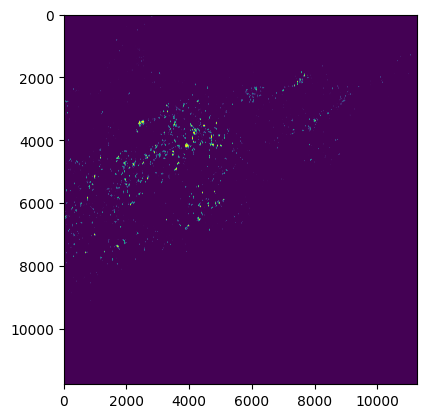

In [13]:
with rasterio.open('/content/mtm_ndvigb_pred_test.tif') as src:
  data = src.read(1)
  print(np.min(data))
  plt.imshow(data)
